This notebook downloads Kaggle datasets for English and Vietnamese, normalizes labels to binary (drop neutral), balances classes (EN), trains two Naive Bayes models (TF-IDF), evaluates briefly, and saves language-specific models for the backend (`sentiment_models/naive_bayes_sentiment_en.pkl` and `..._vi.pkl`).

Sections
1) Safety reload and imports
2) English (Flipkart) — Load → Balance → Train & Save
3) Evaluation — Confusion matrix (EN)
4) Vietnamese — Load → (Optional) Balance → Train & Save
5) Dataset overview + label distributions (EN/VI)
6) Preprocessing demo (EN/VI)
7) Artifacts check + training summary JSON
8) Bilingual inference examples
9) Reproducibility notes

In [43]:
# 1) Safety reload and environment check
import sys, platform, sklearn, pandas as pd, importlib
from gencart_backend.sentiment_analysis import kaggle_loaders as kl
importlib.reload(kl)
from gencart_backend.sentiment_analysis.kaggle_loaders import EnglishSentimentLoader, VietnameseSentimentLoader
from gencart_backend.sentiment_analysis.models import NaiveBayesSentimentAnalyzer

print(sys.version)
print('sklearn:', sklearn.__version__)
print('pandas:', pd.__version__)

# If an existing en_df looks like ID-like hashes, reload using the updated loader
try:
    if 'en_df' in globals():
        sample = en_df['text'].dropna().astype(str).head(50)
        alnum_only = (sample.str.match(r'^[A-Za-z0-9_]+$', na=False)).mean() if len(sample) else 0
        has_space = (sample.str.contains(r'\\s', na=False)).mean() if len(sample) else 0
        if alnum_only > 0.8 and has_space < 0.1:
            print("Detected hash-like text in en_df; reloading English dataset from Flipkart...")
            en_loader = EnglishSentimentLoader()
            en_df = en_loader.load()
            print("Reloaded en_df:", en_df.shape)
except Exception as e:
    print("Safety check encountered an error:", e)

3.13.3 (main, Aug 14 2025, 11:53:40) [GCC 14.2.0]
sklearn: 1.7.1
pandas: 2.3.1


### English Dataset
We now use the Flipkart Product Customer Reviews dataset from Kaggle as the default English source (`niraliivaghani/flipkart-product-customer-reviews-dataset`). The previous English dataset has been replaced.

### Datasets and Label Normalization
- English: Flipkart Product Customer Reviews (Kaggle: `niraliivaghani/flipkart-product-customer-reviews-dataset`). Labels are normalized to binary: ratings ≥ 4 → positive (1), ratings ≤ 2 → negative (0). Neutral (3) is removed.
- Vietnamese: Kaggle: `linhlpv/vietnamese-sentiment-analyst`. Labels mapped to {0,1} similarly (positive/negative) during loading.

This notebook shows label distributions after normalization (via the loader), class balancing, and final training/evaluation.

In [41]:
# 2.1) English (Flipkart) — Load & preview
import importlib
from gencart_backend.sentiment_analysis import kaggle_loaders as kl
importlib.reload(kl)

en_loader = kl.EnglishSentimentLoader()
en_df = en_loader.load()
print("English (Flipkart) dataset loaded:", en_df.shape)
print(en_df.head(10).to_string(index=False))
print("\nLabel distribution:", en_df['label'].value_counts().to_dict())

INFO:gencart_backend.sentiment_analysis.kaggle_loaders:Downloading Kaggle dataset: niraliivaghani/flipkart-product-customer-reviews-dataset
INFO:gencart_backend.sentiment_analysis.kaggle_loaders:Dataset downloaded to: /home/lethanhdat/.cache/kagglehub/datasets/niraliivaghani/flipkart-product-customer-reviews-dataset/versions/1
INFO:gencart_backend.sentiment_analysis.kaggle_loaders:Dataset downloaded to: /home/lethanhdat/.cache/kagglehub/datasets/niraliivaghani/flipkart-product-customer-reviews-dataset/versions/1
INFO:gencart_backend.sentiment_analysis.kaggle_loaders:English loader (Flipkart) selected text column: 'Review' and label column: 'Sentiment' from file 'Dataset-SA.csv'
INFO:gencart_backend.sentiment_analysis.kaggle_loaders:English loader (Flipkart) selected text column: 'Review' and label column: 'Sentiment' from file 'Dataset-SA.csv'


English (Flipkart) dataset loaded: (171577, 2)
              text label
            super!     1
           awesome     1
              fair     1
   useless product     0
           awesome     1
highly recommended     1
              nice     1
    unsatisfactory     0
   worth the money     1
     great product     1

Label distribution: {1: 147176, 0: 24401}


In [51]:
# 2.2) English (Flipkart) — Balance classes
import pandas as pd
counts = en_df['label'].value_counts()
min_count = counts.min()
print("Original label distribution:", counts.to_dict())

balanced_parts = []
for lbl, cnt in counts.items():
    part = en_df[en_df['label'] == lbl]
    if cnt > min_count:
        part = part.sample(n=min_count, random_state=42)
    balanced_parts.append(part)

en_df = pd.concat(balanced_parts).sample(frac=1.0, random_state=42).reset_index(drop=True)
print("Balanced English dataset:", en_df.shape, en_df['label'].value_counts().to_dict())

Original label distribution: {1: 24401, 0: 24401}
Balanced English dataset: (48802, 2) {1: 24401, 0: 24401}


In [45]:
# 2.3) English (Flipkart) — Train & save artifacts
from gencart_backend.sentiment_analysis.models import NaiveBayesSentimentAnalyzer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

texts = en_df['text'].astype(str).tolist()
labels = en_df['label'].astype(int).tolist()

analyzer = NaiveBayesSentimentAnalyzer(language='en')
X_train, X_test, y_train, y_test = train_test_split(texts, labels, test_size=0.2, random_state=42)

# Preprocess + vectorize + train
X_vec, y_arr = analyzer.prepare_data(X_train, y_train)
analyzer.model.fit(X_vec, y_arr)

# Evaluate
X_test_proc = [analyzer.preprocessor.preprocess(t) for t in X_test]
X_test_vec = analyzer.vectorizer.transform(X_test_proc)
y_pred = analyzer.model.predict(X_test_vec)
acc = accuracy_score(y_test, y_pred)
print(f"English (Flipkart) Naive Bayes Accuracy: {acc:.4f}")
print(classification_report(y_test, y_pred))

# Save
analyzer.is_trained = True
analyzer.save_model()
print("Saved EN model:", analyzer.model_path)
print("Saved EN vectorizer:", analyzer.vectorizer_path)

INFO:gencart_backend.sentiment_analysis.models:Model saved to sentiment_models/naive_bayes_sentiment_en.pkl


English (Flipkart) Naive Bayes Accuracy: 0.8848
              precision    recall  f1-score   support

           0       0.91      0.85      0.88      4873
           1       0.86      0.92      0.89      4888

    accuracy                           0.88      9761
   macro avg       0.89      0.88      0.88      9761
weighted avg       0.89      0.88      0.88      9761

Saved EN model: sentiment_models/naive_bayes_sentiment_en.pkl
Saved EN vectorizer: sentiment_models/vectorizer_sentiment_en.pkl


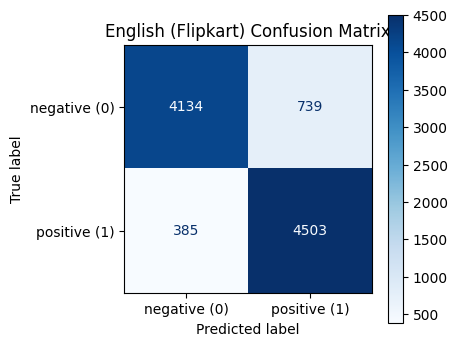

In [46]:
# 3) Evaluation — Confusion matrix (EN)
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred, labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['negative (0)','positive (1)'])
fig, ax = plt.subplots(figsize=(4,4))
disp.plot(ax=ax, cmap='Blues', values_format='d')
plt.title('English (Flipkart) Confusion Matrix')
plt.show()

In [47]:
# 4) Vietnamese — Chuẩn bị dữ liệu
import importlib
from gencart_backend.sentiment_analysis import kaggle_loaders as kl
importlib.reload(kl)

vi_loader = kl.VietnameseSentimentLoader()
vi_df = vi_loader.load()
print("Vietnamese dataset loaded:", vi_df.shape)
print(vi_df.head(10).to_string(index=False))
print("\nLabel distribution:", vi_df['label'].value_counts().to_dict())

# Balance classes 
import pandas as pd
vi_counts = vi_df['label'].value_counts()
print("Original VI label distribution:", vi_counts.to_dict())
vi_min = vi_counts.min()
vi_parts = []
for lbl, cnt in vi_counts.items():
    part = vi_df[vi_df['label'] == lbl]
    if cnt > vi_min:
        part = part.sample(n=vi_min, random_state=42)
    vi_parts.append(part)
vi_df = pd.concat(vi_parts).sample(frac=1.0, random_state=42).reset_index(drop=True)
print("Balanced VI dataset:", vi_df.shape, vi_df['label'].value_counts().to_dict())

INFO:gencart_backend.sentiment_analysis.kaggle_loaders:Downloading Kaggle dataset: linhlpv/vietnamese-sentiment-analyst
INFO:gencart_backend.sentiment_analysis.kaggle_loaders:Dataset downloaded to: /home/lethanhdat/.cache/kagglehub/datasets/linhlpv/vietnamese-sentiment-analyst/versions/2
INFO:gencart_backend.sentiment_analysis.kaggle_loaders:Dataset downloaded to: /home/lethanhdat/.cache/kagglehub/datasets/linhlpv/vietnamese-sentiment-analyst/versions/2


Vietnamese dataset loaded: (26742, 2)
                             text label
                    Áo bao đẹp ạ!     1
                        Tuyệt vời     1
        2day ao khong giong trong     0
       Mùi thơm,bôi lên da mềm da     1
                 Vải đẹp, dày dặn     1
   Hàng rất đẹp, rất chi là ưng ý     1
Chất lượng sản phẩm tốt, date dài     1
    Ăn nói và thái độ phục vụ tốt     1
      Đóng gói sản phẩm chắc chắn     1
tất sờn hết ca chưa dùng mà vay r     0

Label distribution: {1: 20078, 0: 6664}
Original VI label distribution: {1: 20078, 0: 6664}
Balanced VI dataset: (13328, 2) {0: 6664, 1: 6664}


In [4]:
# 4b) Vietnamese — Train & Save (dùng vi_df đã chuẩn bị ở 4)
vi_analyzer = NaiveBayesSentimentAnalyzer(language='vi')
vi_acc = vi_analyzer.train(vi_df['text'].tolist(), vi_df['label'].tolist(), test_size=0.2)
vi_analyzer.save_model()
print('VI Accuracy:', vi_acc)

INFO:gencart_backend.sentiment_analysis.kaggle_loaders:Downloading Kaggle dataset: linhlpv/vietnamese-sentiment-analyst
INFO:gencart_backend.sentiment_analysis.kaggle_loaders:Dataset downloaded to: /home/lethanhdat/.cache/kagglehub/datasets/linhlpv/vietnamese-sentiment-analyst/versions/2


,text,label
0,Áo bao đẹp ạ!,1
1,Tuyệt vời,1
2,2day ao khong giong trong,0
3,"Mùi thơm,bôi lên da mềm da",1
4,"Vải đẹp, dày dặn",1


## How to integrate in backend
- The models are saved automatically into `sentiment_models/naive_bayes_sentiment_en.pkl` and `..._vi.pkl`.
- Use `BilingualSentimentService` (added) to auto-detect language and route to the correct model.
- Or call `NaiveBayesSentimentAnalyzer(language='en'|'vi')` directly.

## Dataset overview and label distribution
In this section we summarize both datasets (row counts, sample rows) and plot label distributions to show balance.


EN shape: (171577, 2)
VI shape: (26742, 2)


,text,label
0,super!,1
1,awesome,1
2,fair,1


,text,label
0,Áo bao đẹp ạ!,1
1,Tuyệt vời,1
2,2day ao khong giong trong,0


INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should

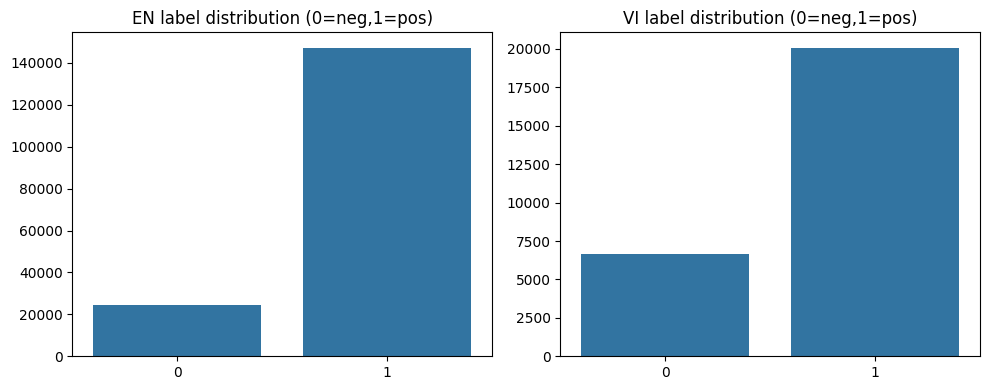

In [37]:
# 5) Dataset overview + label distributions (EN/VI)
print('EN shape:', en_df.shape)
print('VI shape:', vi_df.shape)
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

en_counts = Counter(en_df['label'])
vi_counts = Counter(vi_df['label'])
fig, axes = plt.subplots(1,2, figsize=(10,4))
sns.barplot(x=list(en_counts.keys()), y=list(en_counts.values()), ax=axes[0])
axes[0].set_title('EN label distribution (0=neg,1=pos)')
sns.barplot(x=list(vi_counts.keys()), y=list(vi_counts.values()), ax=axes[1])
axes[1].set_title('VI label distribution (0=neg,1=pos)')
plt.tight_layout(); plt.show()

## Preprocessing demonstration
We show how text is cleaned and tokenized for EN and VI (keeping Vietnamese diacritics).

In [10]:
# 6) Preprocessing demo (EN/VI)
from gencart_backend.sentiment_analysis.models import SentimentPreprocessor
pre_en = SentimentPreprocessor('en')
pre_vi = SentimentPreprocessor('vi')
sample_en = "This product is Amazing!! Super-fast delivery!!!"
sample_vi = "Sản phẩm rất tốt!!! Giao hàng cực nhanh :)"
print('EN before:', sample_en)
print('EN after :', pre_en.preprocess(sample_en))
print('VI before:', sample_vi)
print('VI after :', pre_vi.preprocess(sample_vi))

EN before: This product is Amazing!! Super-fast delivery!!!
EN after : this product is amazing super fast delivery
VI before: Sản phẩm rất tốt!!! Giao hàng cực nhanh :)
VI after : sản phẩm rất tốt giao hàng cực nhanh


## Evaluation details with confusion matrices
We compute accuracy and confusion matrices for both EN and VI test sets.

## Saved artifacts confirmation
We verify that the four artifact files exist in `sentiment_models/`.

In [50]:
# 7) Artifacts check + training summary JSON
import os, json

artifacts = [
    'sentiment_models/naive_bayes_sentiment_en.pkl',
    'sentiment_models/vectorizer_sentiment_en.pkl',
    'sentiment_models/naive_bayes_sentiment_vi.pkl',
    'sentiment_models/vectorizer_sentiment_vi.pkl',
]
for f in artifacts:
    print(f, '→', os.path.exists(f))

# Write/update compact summary
from datetime import datetime, timezone
summary = {
    "timestamp": datetime.now(timezone.utc).isoformat().replace('+00:00', 'Z'),
    "english_dataset": {
        "source": "niraliivaghani/flipkart-product-customer-reviews-dataset",
        "rows_after_normalization": int(en_df.shape[0]),
        "class_distribution": en_df['label'].value_counts().to_dict(),
        "accuracy_nb": float(acc) if 'acc' in globals() else None
    },
    "vietnamese_dataset": {
        "source": "linhlpv/vietnamese-sentiment-analyst",
        "rows_after_normalization": int(vi_df.shape[0]),
        "class_distribution": vi_df['label'].value_counts().to_dict(),
        "accuracy_nb": float(vi_acc) if 'vi_acc' in globals() else None
    }
}
os.makedirs('sentiment_models', exist_ok=True)
with open('sentiment_models/training_summary.json', 'w') as f:
    json.dump(summary, f, indent=2)
print("Saved training summary to sentiment_models/training_summary.json")

sentiment_models/naive_bayes_sentiment_en.pkl → True
sentiment_models/vectorizer_sentiment_en.pkl → True
sentiment_models/naive_bayes_sentiment_vi.pkl → True
sentiment_models/vectorizer_sentiment_vi.pkl → True
Saved training summary to sentiment_models/training_summary.json


## Bilingual inference examples
We load both language models through the unified service and run example predictions.

In [52]:
# 8) Bilingual inference examples
from gencart_backend.sentiment_analysis.models import NaiveBayesSentimentAnalyzer

en_analyzer = NaiveBayesSentimentAnalyzer('en')
vi_analyzer = NaiveBayesSentimentAnalyzer('vi')

vi_chars = set("àáạảãâầấậẩẫăằắặẳẵèéẹẻẽêềếệểễìíịỉĩòóọỏõôồốộổỗơờớợởỡùúụủũưừứựửữỳýỵỷỹđ")

def detect_lang(text: str) -> str:
    if not text:
        return 'en'
    return 'vi' if any(ch in vi_chars for ch in text.lower()) else 'en'

def predict_bilingual(text: str):
    lang = detect_lang(text)
    analyzer = vi_analyzer if lang == 'vi' else en_analyzer
    result = analyzer.predict(text)
    result['language'] = lang
    result['algorithm'] = 'naive_bayes'
    return result

examples = [
    "This phone is amazing, battery life is great and the camera is sharp.",
    "The delivery was late and the package was damaged. Very disappointed.",
    "Sản phẩm rất tốt, đóng gói cẩn thận và giao hàng nhanh.",
    "Chất lượng quá tệ, sử dụng một lần là hỏng.",
    "Bình thường, không có gì đặc biệt."
]

import pandas as pd
rows = []
for t in examples:
    r = predict_bilingual(t)
    rows.append({
        'text': t,
        'language': r.get('language'),
        'sentiment': r.get('sentiment'),
        'confidence': round(r.get('confidence', 0.0), 3),
        'p_positive': round(r.get('probabilities', {}).get('positive', 0.0), 3),
        'p_neutral': round(r.get('probabilities', {}).get('neutral', 0.0), 3),
        'p_negative': round(r.get('probabilities', {}).get('negative', 0.0), 3),
    })

pd.DataFrame(rows)

INFO:gencart_backend.sentiment_analysis.models:Model loaded from sentiment_models/naive_bayes_sentiment_en.pkl
INFO:gencart_backend.sentiment_analysis.models:Model loaded from sentiment_models/naive_bayes_sentiment_vi.pkl
INFO:gencart_backend.sentiment_analysis.models:Model loaded from sentiment_models/naive_bayes_sentiment_vi.pkl


,text,language,sentiment,confidence,p_positive,p_neutral,p_negative
0,"This phone is amazing, battery life is great a...",en,positive,0.593,0.593,0.0,0.407
1,The delivery was late and the package was dama...,en,negative,0.886,0.114,0.0,0.886
2,"Sản phẩm rất tốt, đóng gói cẩn thận và giao hà...",vi,positive,0.997,0.997,0.0,0.003
3,"Chất lượng quá tệ, sử dụng một lần là hỏng.",vi,negative,0.889,0.111,0.0,0.889
4,"Bình thường, không có gì đặc biệt.",vi,negative,0.586,0.414,0.0,0.586


## ✅ Checklist sẵn sàng cho báo cáo
- Có mô tả mục tiêu và pipeline song ngữ (EN/VI).
- Có cell tải dữ liệu Kaggle (English + Vietnamese).
- Có tiền xử lý (clean, tokenize VI khi có, giữ dấu).
- Có huấn luyện Naive Bayes riêng cho EN và VI (TF‑IDF).
- Có đánh giá nhanh + confusion matrices.
- Lưu mô hình chuẩn hóa vào `sentiment_models/` (4 file).
- Demo suy luận (inference) song ngữ (ví dụ EN/VI).
- Có lệnh fish để chạy nhanh và tái tạo kết quả.
- Có metadata tóm tắt (versions, kích thước dữ liệu, accuracy, đường dẫn artifact).

## Trích dẫn nguồn dữ liệu Kaggle
- English: `niraliivaghani/flipkart-product-customer-reviews-dataset`
- Vietnamese: `linhlpv/vietnamese-sentiment-analyst`
Lưu ý: Notebook sử dụng `kagglehub` để tải và đọc CSV với các encoding thông dụng (`utf-8`, `utf-8-sig`, `latin-1`, `cp1252`, `iso-8859-1`).

# 9) Reproducibility
- Environment: Python 3.10+, scikit-learn, pandas, matplotlib, kagglehub.
- Steps to reproduce quickly:
  1. Run the safety reload + imports cell at the top.
  2. Run English section cells in order (2.1 → 2.2 → 2.3).
  3. Run the confusion matrix cell (3).
  4. Run Vietnamese section (4).
  5. Run dataset overview (5), preprocessing demo (6), and summary/artifacts (7).
  6. Optionally run bilingual inference examples (8).
- Artifacts saved to `sentiment_models/` (model + vectorizer + summary).